In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from configs import load_configs, load_experimental_results
from factorization.config import IMAGE_DIR
from factorization.models.mlp import Model


def get_names(name):
    match name:
        case "factor":
            return "exp1_factor", ["input_factors", "output_factors"]
        case "dim":
            return "exp1_dim", ["emb_dim"]
        case "layer":
            return "exp1_layer", ["nb_layers"]
        case "split":
            return "exp1_split", ["data_split"]
        case "ffn":
            return "exp1_ffn", ["ffn_dim"]
        case "bernouilli":
            return "filtration", ["bernouilli"]


def plot(name):
    file_path, study_factors = get_names(name)

    kwargs = {
        # "bernouilli_seed": 0,
        "final": False, # wether to load last epoch only
    }
    all_configs = load_configs(file_path)
    res = load_experimental_results(all_configs, **kwargs)

    res['flops'] = Model.get_flops(res['emb_dim'], res['ffn_dim'], res['nb_layers'], res['output_size'])
    res['flops'] *= res['epoch'] * res['data_split']

    all_factors = ['input_factors', 'output_factors', 'parents', 'bernouilli', 'alphas', 'data_split', 'emb_dim', 'ffn_dim', 'nb_layers', 'mode', 'bernouilli_seed', 'seed', 'input_size', 'output_size', 'data_complexity']
    ignored = (
        ['seed', 'unique_id', 'loss', 'test_loss', 'batch_size', 'train_entropy', 'test_entropy']
        + list(kwargs.keys())
        + [key for key in all_factors if key not in study_factors]
    )
    columns = [col for col in res.columns if col not in ignored]

    mean = res.groupby(columns)[['loss', 'test_loss']].mean().reset_index()
    std = res.groupby(columns)[['loss', 'test_loss']].std().reset_index()

    xaxis = 'flops'
    xaxis = 'epoch'
    mean.set_index(xaxis, inplace=True)
    std.set_index(xaxis, inplace=True)

    all_mean = []
    all_std = []

    keys = study_factors
    all_vals = [np.sort(res[key].unique()).tolist() for key in keys]

    for vals in product(*all_vals):
        ind = np.ones(len(mean), dtype=bool)
        for key, val in zip(keys, vals):
            ind &= (mean[key] == val)
        all_mean.append(mean[ind])
        all_std.append(std[ind])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, name in zip(axes, ['test_loss', 'loss']):
        color = 'C0'
        legend = []
        all_plots = []
        for val, val_std in zip(all_mean, all_std):
            a, = ax.plot(val[name])
            all_plots.append(a)
            # ax.fill_between(val.index, val[name] - val_std[name], val[name] + val_std[name], alpha=0.5)
            leg = ' '.join([f'{key}={val[key].values[0]}' for key in keys])
            legend.append(leg)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(xaxis)
        ax.set_ylabel('Loss')
        ax.tick_params(axis='y', labelcolor=color)
        ax.set_title(name)
        # ax.set_ylim(4.5, 4.75)

    ax = axes[2]
    ax.axis('off')
    ax.legend(all_plots, legend)

    # ax2 = ax.twinx()
    # color = 'C1'
    # for val, val_std in zip([compression_mean, mean1], [compression_std, std]):
    #     ax2.plot(val['nb_factors'], color=color)
    # ax2.tick_params(axis='y', labelcolor=color)
    # ax2.set_ylabel(r'Number $k$ of factors')

    ax.grid()
    fig.savefig(IMAGE_DIR / f'{study_factors[0]}.pdf')
    # ax2.grid(alpha=0.25)

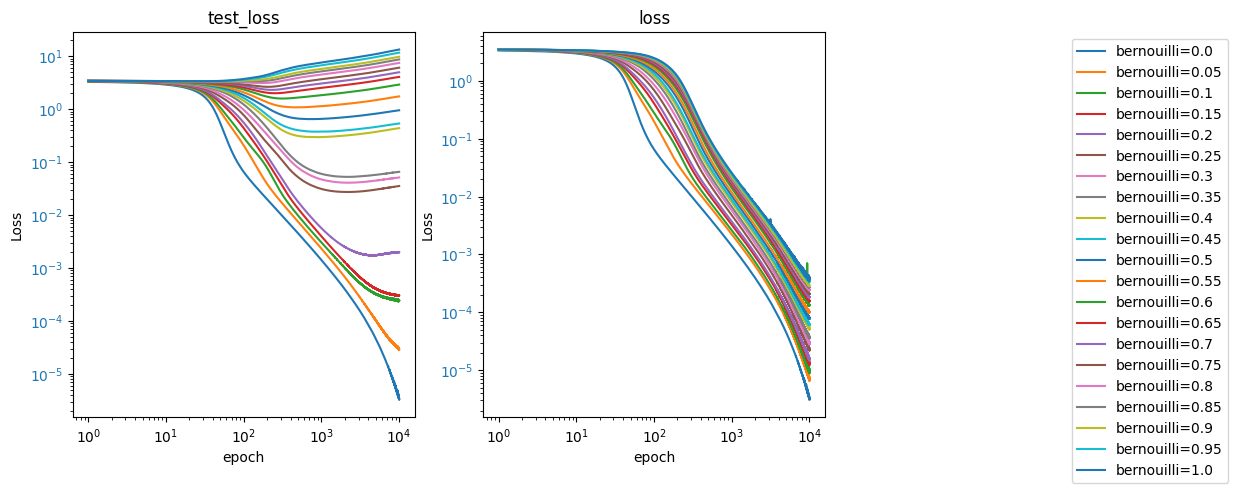

In [15]:
plot("bernouilli")